### For testing the emulator vs theory for different tracers and cosmology

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from getdist import plots
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from cosmoprimo.fiducial import DESI, AbacusSummit
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging
setup_logging()  # for logging messages

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX, GET_RECON_BIAS
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX, PLANCK_COSMOLOGY
from fit_cubic_tools import get_observable_likelihood, load_bins, load_mock_cov, load_cubic_sys_fns
%load_ext autoreload
%autoreload 2

Z_VSMEAR = REDSHIFT_LSS_VSMEAR
Z_CUBIC = REDSHIFT_LSS_CUBICBOX
base_dir = '/pscratch/sd/s/shengyu/results/cubic'

In [3]:
fit = 'FM' # FM: Full-Modeling, SF: Shape-Fit
task = f'{fit}fit_cubic_sys'
theory_model = 'vel' # vel, folps
option = 'None' # '_4.5logAs', _fix_ns, '_dv_obs'
# rsf = False
# cov_type = 'EZcov_fn_rsf' if rsf == True else 'EZcov_fn'

corr_type = 'pk'
bins_type = 'y3_sys'
sys_model = 'standard'
if option == '_dv_obs':
    sys_model = 'dv-obs'
(kmin, kmax, kbin, lenk) = load_bins(corr_type, bins_type)
klim = {ell*2: (kmin,kmax,kbin) for ell in range(2)}

for rsf in [True]:
    cov_type = 'EZcov_fn_rsf' if rsf == True else 'EZcov_fn'
    for tracer in ['LRG','ELG','QSO']:
        for z_eff, (zmin, zmax) in zip(Z_CUBIC[tracer], Z_VSMEAR[tracer]):
            data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": sys_model, "grid_cosmo": "000"}
            fit_args = {"corr_type": 'pk', "bins_type": 'y3_sys', "cov_type": cov_type, "theory_model": theory_model, "option":option}
            (likelihood, _, theory) = get_observable_likelihood(task, data_args, fit_args)
            # for param in likelihood.varied_params:
                # print(param, param.prior)
            emulator_fn = base_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}.npy'
            if rsf == True:
                emulator_fn = base_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}_rscov.npy'  
                if option != 'None':
                    emulator_fn = base_dir+f'/emulator/extra/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}_rscov{option}.npy'
            print(data_args,flush=True)
            print(fit_args,flush=True)
            print(emulator_fn,flush=True)
            if not os.path.exists(emulator_fn):
                emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
                emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
                emulator.fit()
                emulator.save(emulator_fn)

Loading exist EZmocks covariance


/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_LRG_z0.4-0.6_k0.02-0.2_rsfDR2.txt
[000046.04] [0/1] 04-08 07:38  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph021/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph017/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph019/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph020/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0

KeyboardInterrupt: 

In [15]:
fit = 'FM'
task = f'{fit}fit_cubic_sys'
theory_model  = 'folps'

tracer = 'LRG'
(zmin, zmax) = Z_VSMEAR[tracer][0]
z_eff = Z_CUBIC[tracer][0]
data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": 'standard', "grid_cosmo": "000"}
fit_args = {"corr_type": 'pk', "bins_type": 'y3_sys', "cov_type": 'EZcov_fn_rsf', "theory_model": theory_model}
(_, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
emulator_fn = base_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin:.1f}-{zmax:.1f}_{theory_model}.npy'

theory_1 = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(base_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin:.1f}-{zmax:.1f}_{theory_model}.npy'))
theory_2 = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(base_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin:.1f}-{zmax:.1f}_{theory_model}_rscov.npy'))

Loading exist EZmocks covariance


/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_LRG_z0.4-0.6_k0.02-0.2_rsfDR2.txt
[000306.10] [0/1] 04-08 07:42  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph021/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph017/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph019/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph020/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0

In [8]:
k = observable.k[0]
pk = observable.data
cov = observable.covariance
std = np.sqrt(np.diag(cov))

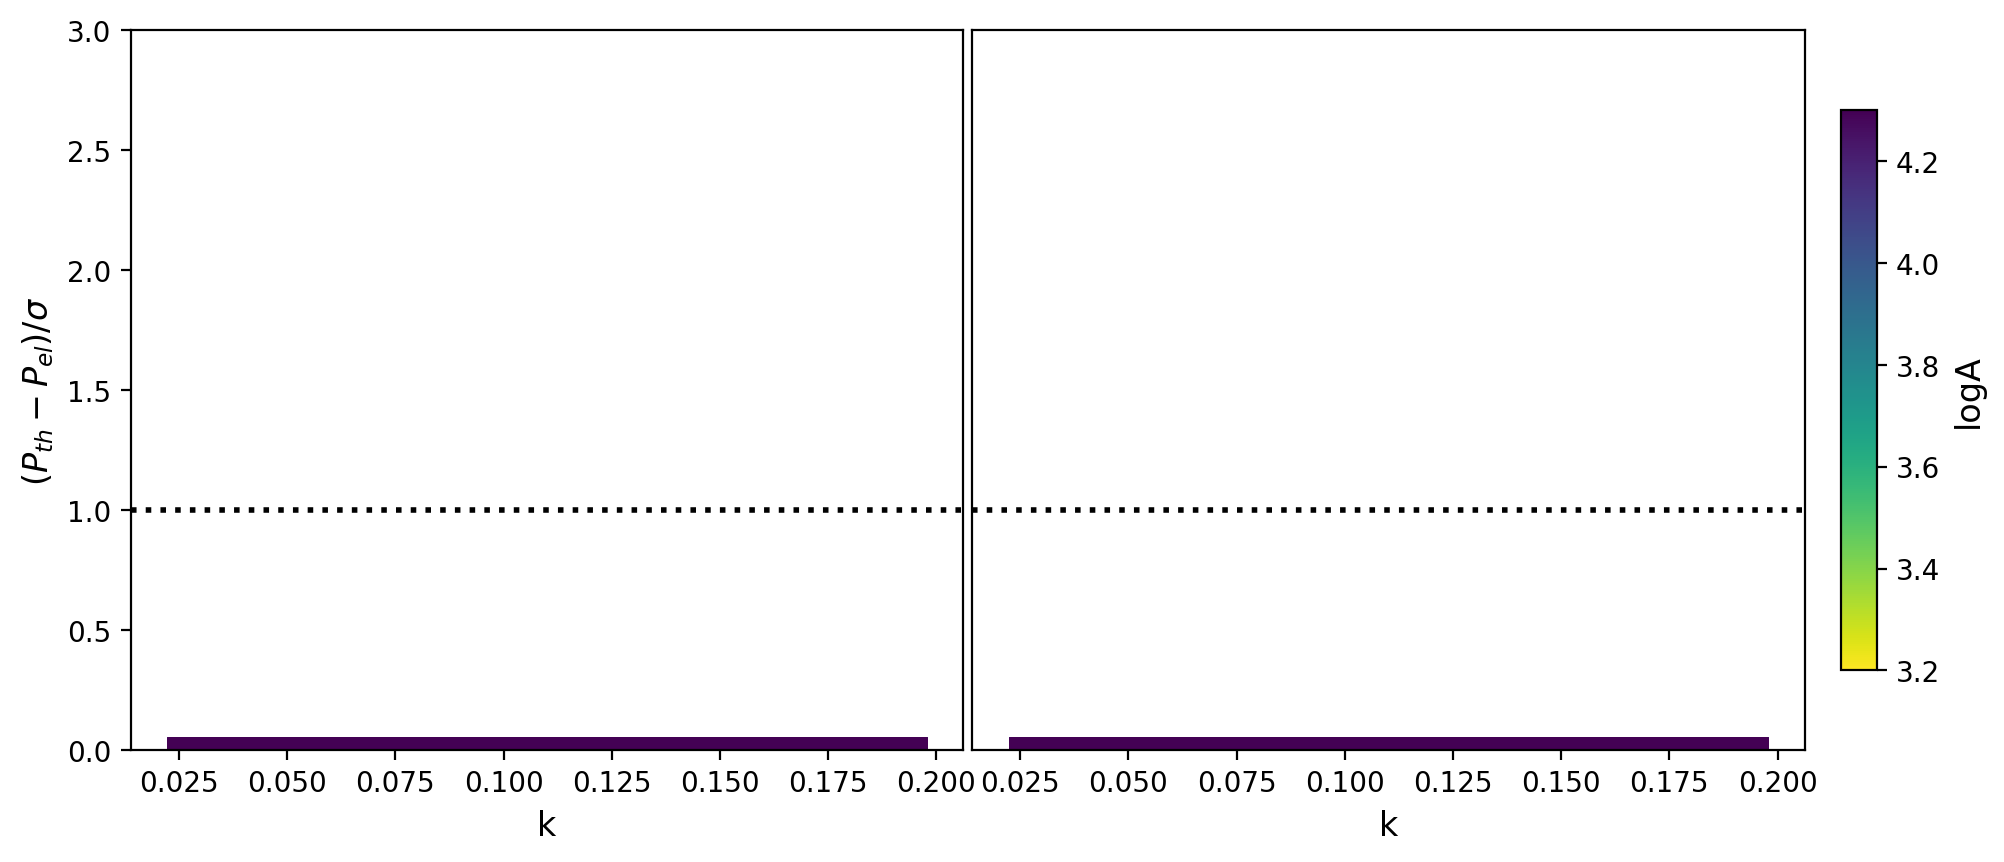

In [19]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

param = 'logA'
param_grid = {
    # 'omega_cdm': np.linspace(0.02, 0.12, 50),
    'omega_cdm': np.linspace(0.12, 0.24, 50),
    # 'logA': np.linspace(1.4, 3.1, 50),
    'logA': np.linspace(3.2, 4.3, 50),
    # 'h': np.linspace(0.4, 0.67, 50),
    'h': np.linspace(0.67, 0.9, 50)
}
values = param_grid[param]
cmap = plt.cm.viridis_r
norm = Normalize(vmin=values.min(), vmax=values.max())
colors = cmap(np.linspace(0, 1, len(values)))

fig = plt.figure(figsize=(9, 4))
gs = gridspec.GridSpec(1,2,wspace=0.01,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)
for ill in range(2):
    ax = plt.subplot(gs[ill])
    for i,value in enumerate(param_grid[param]):
        # plt.plot(k, k*theory(logA=value)[0], color = f'C3', ls ='-', label = 'theory')
        # plt.plot(k, k*theory_el(logA=value)[0], color = f'C4', ls='--', label = 'emulator')
        diff = abs(theory_1(logA=value)[ill]-theory_2(logA=value)[ill])/std[ill]
        plt.fill_between(k, diff+0.05, diff-0.05, color = colors[i])
    # plt.legend(loc = 2)
    plt.axhline(y=1, color = 'black', ls=':', lw = 2)
    # plt.title(f'{tracer} {theory_model} emulator test for "{param}"')
    plt.ylim([0, 3])
    plt.xlabel('k')
    if ill == 0:
        plt.ylabel(r'($P_{th}-P_{el})/\sigma $')
    if ill > 0:
        plt.tick_params(axis='y', which='both', left=False, labelleft=False)
# Add colorbar on the right of the whole figure
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(param)

In [7]:
k = observable.k[0]
pk = observable.data
cov = observable.covariance
std = [np.sqrt(np.diag(cov))[:lenk], np.sqrt(np.diag(cov))[lenk:]]

Text(0, 0.5, '($P_{th}-P_{el})/\\sigma $')

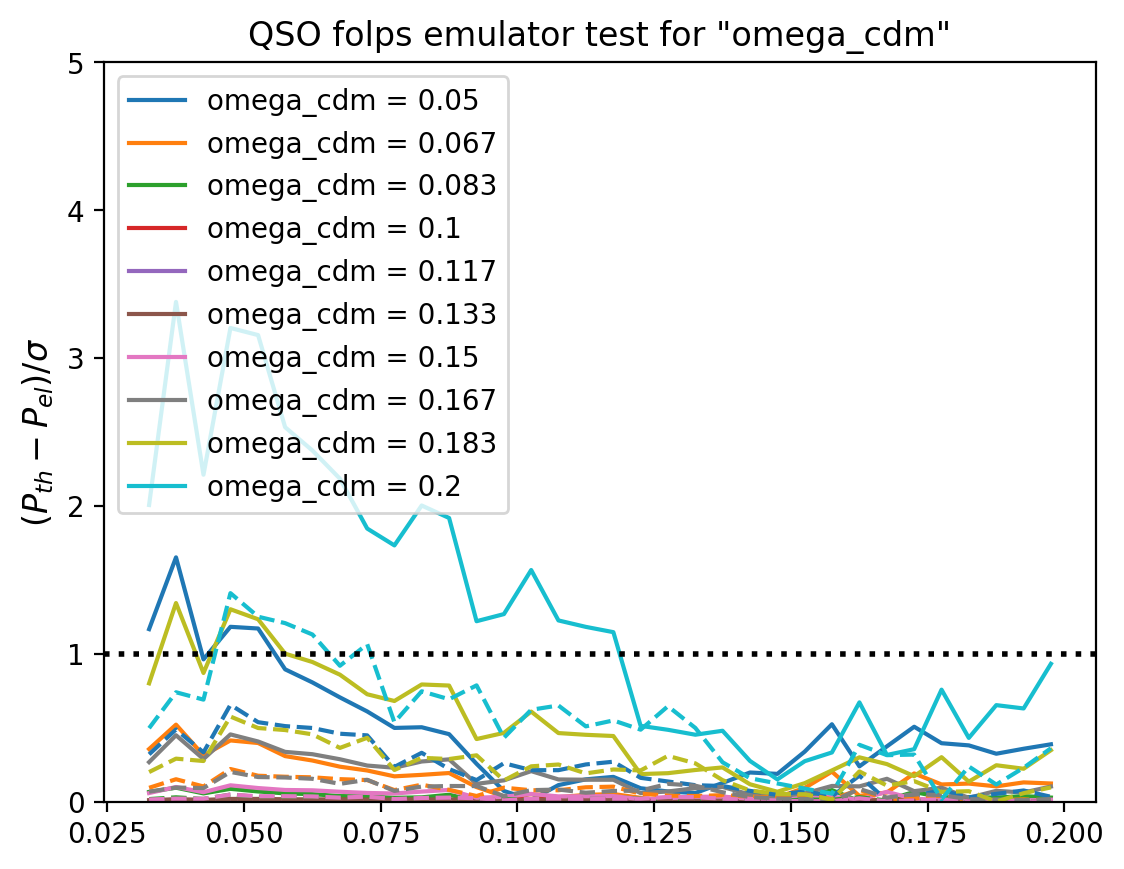

In [ ]:



plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

param = 'omega_cdm'
param_grid = {
    'omega_cdm' :np.linspace(0.05, 0.20, 10),
    'logA': np.linspace(2.5, 3.5, 10),
    'h': np.linspace(0.5, 0.80, 10)
}
fig = plt.figure(figsize=(16, 3))
gs = gridspec.GridSpec(1,4,wspace=0.15,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)

for ill in range(2):
    ax = plt.subplot(gs[ill])
    for i,value in enumerate(param_grid[param]):
        # plt.plot(k, k*theory(logA=value)[0], color = f'C3', ls ='-', label = 'theory')
        # plt.plot(k, k*theory_el(logA=value)[0], color = f'C4', ls='--', label = 'emulator')
        plt.plot(k, abs(theory(omega_cdm=value)[ill]-theory_el(omega_cdm=value)[ill])/std[ill], color = f'C{i}', label = f"{param} = {value}" )
    plt.legend(loc = 2)
    plt.axhline(y=1, color = 'black', ls=':', lw = 2)
    plt.title(f'{tracer} {theory_model} emulator test for "{param}"')
    plt.ylim([0, 5])
    plt.ylabel(r'($P_{th}-P_{el})/\sigma $')

In [ ]:
theory_model = 'folps' # vel, folps
task = f'FMfit_cubic_sys'
corr_type = 'pk'
bins_type = 'y3_sys'
cov_type  = 'covbox'

for tracer in ['LRG','ELG','QSO']:
    for z_eff, (zmin, zmax) in zip(Z_CUBIC[tracer], Z_VSMEAR[tracer]):
        data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": 'standard', "grid_cosmo": "000"}
        fit_args = {"corr_type": corr_type, "bins_type": bins_type, "cov_type": cov_type, "theory_model": theory_model}
        emulator_fn = base_dir+f'/emulator/emulator_{tracer}_z{zmin:.1f}-{zmax:.1f}_{theory_model}.npy'
        if not os.path.exists(emulator_fn):
            (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
            emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
            emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
            emulator.fit()
            emulator.save(emulator_fn)